# Analysis of U20 lab-based replication

Load libraries and data in.

In [41]:
%matplotlib inline

import pandas as pd
import seaborn as sns
from numpy import * 
import os

os.chdir('/Users/Alexander/Documents/Science/U20/POS/English/scripts/')

%run clean-data.py # concatenates and cleans data into DataFrame called df
# df = pd.read_csv('../data/test/ENGtest.csv')

Check that data were loaded correctly.

In [42]:
df.sample(10)

,age,buttonA,buttonB,buttonC,buttonD,cond,date,gender,iso,modInner,modOuter,nbMods,noun,nounSing,post,response,responseButton,suj,trial
9471,22.0,pitchers ten dirty,dirty ten pitchers,pitchers dirty ten,ten dirty pitchers,num-adj,2017-11-24 17:03,F,1.0,dirty,ten,2,pitchers,pitcher,NaN,pitchers dirty ten,2.0,ENG4014,21.0
672,18.0,five these ribbons,these five ribbons,ribbons five these,ribbons these five,dem-num,2017-11-14 14:13,F,1.0,five,these,2,ribbons,ribbon,NaN,ribbons five these,2.0,ENG2001,22.0
3903,23.0,boxes five,five boxes,NaN,NaN,dem-num,2017-11-16 16:22,F,NaN,NaN,five,1,boxes,box,1.0,boxes five,0.0,ENG4007,3.0
14271,20.0,stone three leaves,three stone leaves,leaves stone three,leaves three stone,num-adj,2017-11-16 17:06,M,1.0,stone,three,2,leaves,leaf,NaN,leaves stone three,2.0,ENG4008,21.0
4926,21.0,purple dart,dart purple,NaN,NaN,dem-adj,2018-01-25 12:19,F,NaN,NaN,purple,1,dart,dart,1.0,dart purple,1.0,ENG4027,26.0
6265,22.0,four those spatulas,spatulas four those,spatulas those four,those four spatulas,dem-num,2017-11-23 14:55,F,0.0,four,those,2,spatulas,spatula,NaN,spatulas those four,2.0,ENG2007,15.0
17323,18.0,two chairs,chairs two,NaN,NaN,num-adj,2017-11-16 14:58,M,NaN,NaN,two,1,chairs,chair,1.0,chairs two,1.0,ENG1002,23.0
7140,18.0,vases those,those vases,NaN,NaN,dem-num,2017-11-14 14:04,F,NaN,NaN,those,1,vases,vase,1.0,vases those,0.0,ENG3001,40.0
9554,19.0,handbags those six,handbags six those,those six handbags,six those handbags,dem-num,2017-12-05 14:09,F,1.0,six,those,2,handbags,handbag,NaN,handbags six those,1.0,ENG4016,4.0
16749,19.0,nine pitchers,pitchers nine,NaN,NaN,dem-num,2017-11-23 14:54,F,NaN,NaN,nine,1,pitchers,pitcher,1.0,pitchers nine,1.0,ENG3010,49.0


Note that these data are only from the testing phase, so unlike in the original experiment, no separation of the data is necessary.

Check how many participants we have in each condition:

In [43]:
df.groupby('cond').suj.nunique()

cond
dem-adj    32
dem-num    38
num-adj    34
Name: suj, dtype: int64

Check by participant accuracy on single-modifier trials.  The critical column is `post` denoting whether or not (1 or 0) a response was postnominal.

In [44]:
df[df.nbMods == 1].groupby(['suj', 'cond']).post.mean().sample(20)

suj      cond   
ENG4014  num-adj    1.0
ENG1008  num-adj    1.0
ENG4017  num-adj    1.0
ENG4019  dem-num    1.0
ENG1003  dem-adj    1.0
ENG3024  dem-adj    1.0
ENG3003  dem-adj    1.0
ENG4018  dem-adj    1.0
ENG3025  dem-num    1.0
ENG2023  num-adj    1.0
ENG4011  num-adj    1.0
ENG3017  num-adj    1.0
ENG3001  dem-num    1.0
ENG1009  dem-adj    1.0
ENG3004  dem-num    1.0
ENG1005  num-adj    1.0
ENG3010  dem-num    1.0
ENG4026  num-adj    1.0
ENG4013  dem-num    1.0
ENG1001  dem-num    1.0
Name: post, dtype: float64

Plot histogram of single-modifier trial accuracy.

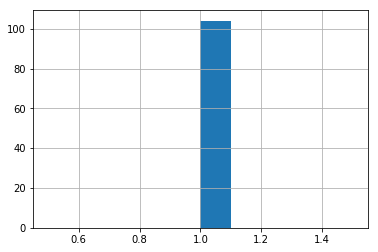

In [45]:
df[df.nbMods == 1].groupby(['suj', 'cond']).post.mean().hist()

In [46]:
aggregators = {'iso':mean}

gp = df[df.nbMods == 2].groupby(['suj', 'cond'], as_index=False).agg(aggregators)

[(-0.05, 1.05)]

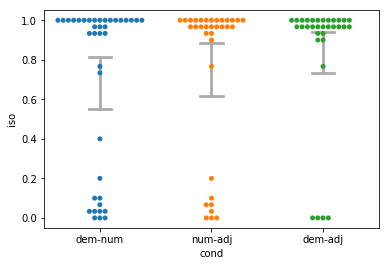

In [47]:
fig, ax = subplots()

order=['dem-adj', 'num-adj', 'dem-num']

sns.barplot(x='cond', y='iso', data=gp, ax=ax, alpha=0, capsize=0.2, errcolor='darkgrey', order=order)
sns.swarmplot(x='cond', y='iso', data=gp, ax=ax, order=order)

ax.set(ylim=(-0.05,1.05))

Prepare to do R modelling.

In [48]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Load in data and create subsets on which each model will be run.

In [49]:
%%R
library('lme4')
setwd('/Users/Alexander/Documents/Science/U20/POS/English/scripts/')

d <- read.csv('../data/test/ENGtest.csv')
test <- subset(d, d$nbMods==2) # only select two modifier trials

testAdjDem <- subset(test, test$cond=="dem-adj")
testAdjNum <- subset(test, test$cond=="num-adj")
testNumDem <- subset(test, test$cond=="dem-num")

Run models for the adj-dem condition, and test whether intercept is significantly different from chance level.

In [50]:
%%R

m1AdjDem <- glmer(iso ~ 1 + (1|suj) + (1|nounSing), family=binomial, data=testAdjDem)
m0AdjDem <- glmer(iso ~ 0 + (1|suj) + (1|nounSing), family=binomial, data=testAdjDem)

anova(m1AdjDem, m0AdjDem)

Data: testAdjDem
Models:
m0AdjDem: iso ~ 0 + (1 | suj) + (1 | nounSing)
m1AdjDem: iso ~ 1 + (1 | suj) + (1 | nounSing)
         Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
m0AdjDem  2 721.53 733.69 -358.76   717.53                             
m1AdjDem  3 708.13 726.38 -351.06   702.13 15.398      1  8.708e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Run models for the adj-num condition, and test whether intercept is significantly different from chance level.

In [51]:
%%R

m1AdjNum <- glmer(iso ~ 1 + (1|suj) + (1|nounSing), family=binomial, data=testAdjNum)
m0AdjNum <- glmer(iso ~ 0 + (1|suj) + (1|nounSing), family=binomial, data=testAdjNum)

anova(m1AdjNum, m0AdjNum)

Data: testAdjNum
Models:
m0AdjNum: iso ~ 0 + (1 | suj) + (1 | nounSing)
m1AdjNum: iso ~ 1 + (1 | suj) + (1 | nounSing)
         Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
m0AdjNum  2 928.17 940.44 -462.08   924.17                             
m1AdjNum  3 916.99 935.40 -455.49   910.99 13.178      1  0.0002832 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Run models for the num-dem condition, and test whether intercept is significantly different from chance level.

In [52]:
%%R

m1NumDem <- glmer(iso ~ 1 + (1|suj) + (1|nounSing), family=binomial, data=testNumDem)
m0NumDem <- glmer(iso ~ 0 + (1|suj) + (1|nounSing), family=binomial, data=testNumDem)

anova(m1NumDem, m0NumDem)

Data: testNumDem
Models:
m0NumDem: iso ~ 0 + (1 | suj) + (1 | nounSing)
m1NumDem: iso ~ 1 + (1 | suj) + (1 | nounSing)
         Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
m0NumDem  2 1331.3 1343.9 -663.67   1327.3                             
m1NumDem  3 1320.2 1339.0 -657.09   1314.2 13.149      1  0.0002877 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
